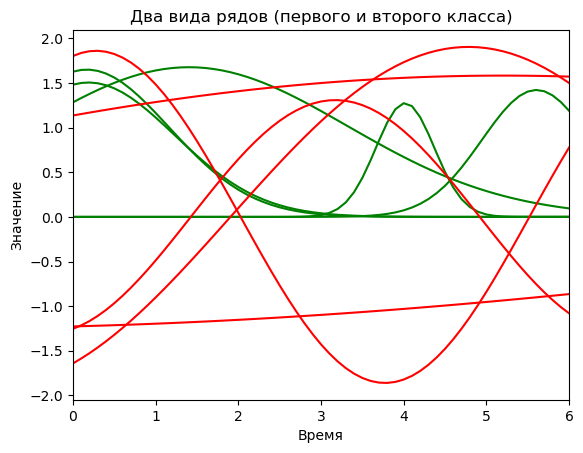

data.shape = (12200, 4)
data.id.nunique() = 200
dataPivoted.shape = (200, 62)
train.shape = (120, 62)
test.shape  = (80, 62)
H.shape = (5, 61)
W_train.shape = (120, 5)
W_test.shape = (80, 5)
trainSet.shape = (120, 6)
testSet.shape = (80, 6)

Value counts train:
 label
0    60
1    60
Name: count, dtype: int64

Value counts test:
 label
0    40
1    40
Name: count, dtype: int64


/var/folders/zn/kyqq10rn5p9gl6tpqh15k7580000gn/T/ipykernel_67234/1746628754.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataPivoted['label'].iloc[N:] = 1


,W_0,W_1,W_2,W_3,W_4,label
0,0.526967,0.568691,0.851825,0.229418,1.087545,0
1,0.915421,1.114792,0.426635,0.391599,1.128027,0
2,0.273371,0.707296,0.635233,0.203901,1.864772,0


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.decomposition import NMF

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from math import isnan

N = 100 ## количество семплов каждого класса
Nvis = 5 ## сколько семплов будем визуализировать
timePoints = 61  ## количество элементов в каждом из рядов

df = pd.DataFrame()
data = pd.DataFrame()
t = np.linspace(0, 6, timePoints) 

random.seed(42)

## генерируем семплы первого класса
for i in range(N):
    t0 = 2*np.pi*random.random()
    a1 = 5*random.random()
    A = 1 + random.random()        
    
    df['t']  = t                   ## ось времени
    df['y']  = A*np.exp(-(df.t-t0)**2/2/a1)  ## значения временного ряда
    df['label'] = 1                ## класс временного ряда 
    df['id'] = i                   ## номер временного ряда
    
    #data = data.append(df)         ## добавляем семпл в общий дейтафрейм
    data = pd.concat([data, df], ignore_index=True)
    if i < Nvis:                   ## визуализируем первые Nvis-штук
        plt.plot(df.t, df.y, color='g') 
    
## генерируем семплы второго класса    
for i in range(N, 2*N):
    A = 1 + random.random()          ## амплитуда
    w = 0 + random.random()          ## частота
    ph = 2*np.pi * random.random()   ## фаза
    
    df['t']  = t                     ## ось времени
    df['y']  = A*np.sin(t*w + ph)    ## значения временного ряда
    df['label'] = 0                  ## класс временного ряда 
    df['id'] = i                     ## номер временного ряда
    
    #data = data.append(df)           ## добавляем семпл в общий дейтафрейм
    data = pd.concat([data, df], ignore_index=True)
    if i < Nvis+N:                   ## визуализируем первые Nvis-штук
        plt.plot(df.t, df.y, color='r') 
    
## cдвигаем все значения вверх, чтобы все значения были положительными    
data['y'] = data.y + np.abs(data.y.min())
    
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title('Два вида рядов (первого и второго класса)')
plt.xlim([t[0], t[-1]])
plt.show()

print('data.shape =', data.shape)
print('data.id.nunique() =', data.id.nunique())
data.head(3)

dataPivoted = data.pivot(index='id', columns='t', values='y')
dataPivoted.reset_index(drop=True)
dataPivoted['label'] = 0
dataPivoted['label'].iloc[N:] = 1
print('dataPivoted.shape =', dataPivoted.shape)
dataPivoted.head()

# train, test = np.split(dataPivoted, [int(0.6*len(dataPivoted))])
train, test = train_test_split(dataPivoted, test_size=0.4, random_state=42) 
print('train.shape =', train.shape)
print('test.shape  =', test.shape)

## составляем список колонок со временем
timeColumns = train.drop('label', axis=1).columns

## факторизуем (раскладываем исходную матрицу на две)
## описываем требования к разложению (основное - раскладываем на три компоненты)
model = NMF(n_components=5, init='nndsvd', random_state=42, tol=0.001, max_iter=5000, solver='cd')
## находим функции разложения и извлекаем их
model.fit(train[timeColumns])
H = model.components_
## получаем коэффициенты разложения для тренировочного и тестового сетов
W_train = model.transform(train[timeColumns])
W_test  = model.transform(test[timeColumns])

print('H.shape =', H.shape)
print('W_train.shape =', W_train.shape) # выделенные признаки
print('W_test.shape =',  W_test.shape)  # выделенные признаки

trainSet = pd.DataFrame()
testSet = pd.DataFrame()

## записываем фичи в дейтафрейм
for i in range(np.shape(W_train)[1]):
    trainSet['W_' + str(i)] = W_train[:,i]
    
for i in range(np.shape(W_test)[1]):
    testSet['W_' + str(i)] = W_test[:,i]
    
## добавляем классы исходного ряда    
trainSet['label'] = train.label.values
testSet['label']  = test.label.values        

print("trainSet.shape =", trainSet.shape)
print("testSet.shape =",  testSet.shape)
print()
print('Value counts train:\n', trainSet.label.value_counts())
print()
print('Value counts test:\n', testSet.label.value_counts())

trainSet.head(3)

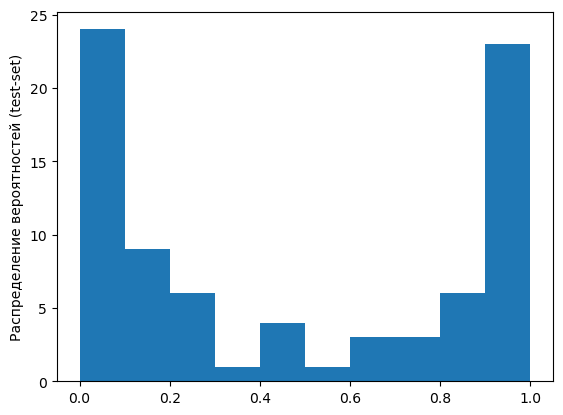

  features  importances
3      W_3     0.404465
2      W_2     0.229784
4      W_4     0.173027
1      W_1     0.137276
0      W_0     0.055448

   Pos  Neg
0   38    2
1    6   34

AUC = 0.972  Точность = 0.900



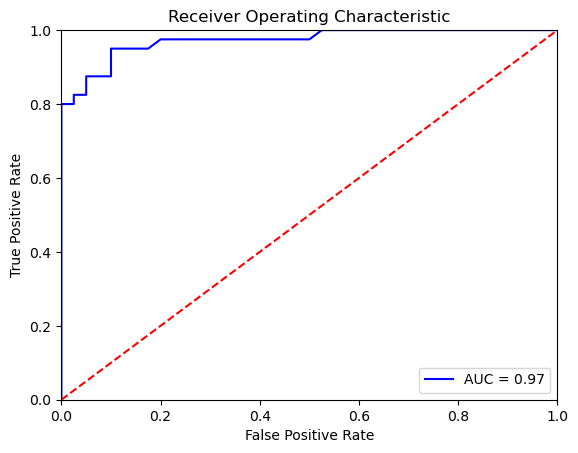

H[0][0] 0.0
[3.2376884]


In [16]:
# Машинное обучение

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from math import isnan

featureList = trainSet.drop('label', axis=1).columns

## параметры классификатора
params = {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'max_features' : 1.0, 'class_weight' : 'balanced',
         'random_state': 42}

## обучаем классификатор
clf = RandomForestClassifier(**params).fit(trainSet[featureList], trainSet['label'])

## делаем предсказание на тестовом наборе
y_pred = clf.predict(testSet[featureList])
y_pred_proba = clf.predict_proba(testSet[featureList])[:, 1] ## вероятности

## визуализируем вероятности для предсказаний
import matplotlib.pyplot as plt
plt.hist(y_pred_proba)
plt.ylabel('Распределение вероятностей (test-set)')
plt.show()

## создадим для удобства дейтафрейм с результатами
res = testSet
res['pred'] = y_pred 
res['pred_proba'] = y_pred_proba

## получаем из классификатора важность фич и отображаем их
ftmprt = pd.DataFrame()
ftmprt['features'] = featureList
ftmprt['importances'] = clf.feature_importances_
ftmprt = ftmprt.sort_values('importances', ascending=False)
print(ftmprt.head(20))
print()
proba = res.pred_proba

# confusion matrix
CM = confusion_matrix(res['label'], res['pred'])
CM_DF = pd.DataFrame(data=CM, columns = ['Pos', 'Neg'])
print(CM_DF)

## считаем матрицу ошибок
FPR, TPR, thresholds = roc_curve(res['label'], res['pred_proba'])
roc_auc = auc(FPR, TPR)
acc = res[res['pred'] == res['label']].shape[0] / res.shape[0]
print(f"\nAUC = {roc_auc:.3f}  Точность = {acc:.3f}\n")

# ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(FPR, TPR, 'b', label=f'AUC = {roc_auc:.2f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('H[0][0]', H[0][0])

reconstr = W_train[0].dot(H)
print(reconstr[55:56])
